In [2]:
import os, random, shutil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from glob import glob
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications import MobileNetV2
from PIL import Image 

print('a')

a


In [3]:
path_train_new = os.path.join('./data/train_by_category/img_category')

train_list = glob(os.path.join(path_train_new, '*', '*.jpg'))

print(len(train_list))

dir_list = sorted(glob(os.path.join(path_train_new, '*')))

print(dir_list)

train_dir = './data/train_by_category/img_category'

tmplist = []
for i in dir_list:
    tmplist.append(i[38:])

print(tmplist)

288182
['./data/train_by_category/img_category/Blazer', './data/train_by_category/img_category/Blouse', './data/train_by_category/img_category/Bomber', './data/train_by_category/img_category/Button-Down', './data/train_by_category/img_category/Cardigan', './data/train_by_category/img_category/Chinos', './data/train_by_category/img_category/Coat', './data/train_by_category/img_category/Culottes', './data/train_by_category/img_category/Cutoffs', './data/train_by_category/img_category/Dress', './data/train_by_category/img_category/Flannel', './data/train_by_category/img_category/Henley', './data/train_by_category/img_category/Hoodie', './data/train_by_category/img_category/Jacket', './data/train_by_category/img_category/Jeans', './data/train_by_category/img_category/Jeggings', './data/train_by_category/img_category/Jersey', './data/train_by_category/img_category/Joggers', './data/train_by_category/img_category/Jumpsuit', './data/train_by_category/img_category/Kimono', './data/train_by_cat

In [4]:
train_datagen = ImageDataGenerator(rescale=1/255, validation_split=0.2)

batch_size=100

# classes=[str(x) for x in range(len(dir_list))]
classes = tmplist

print(classes)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    classes=classes, # ['cats', 'dogs']
    target_size=(299,299),
    batch_size=batch_size, 
    class_mode='categorical',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    classes=classes,
    target_size=(299,299),
    batch_size=batch_size, 
    class_mode='categorical',
    subset='validation')

nr_of_classes = len(train_generator.class_indices)
print(nr_of_classes)

['Blazer', 'Blouse', 'Bomber', 'Button-Down', 'Cardigan', 'Chinos', 'Coat', 'Culottes', 'Cutoffs', 'Dress', 'Flannel', 'Henley', 'Hoodie', 'Jacket', 'Jeans', 'Jeggings', 'Jersey', 'Joggers', 'Jumpsuit', 'Kimono', 'Leggings', 'Parka', 'Poncho', 'Romper', 'Shorts', 'Skirt', 'Sweater', 'Sweatpants', 'Sweatshorts', 'Tank', 'Tee', 'Top', 'Trunks']
Found 230560 images belonging to 33 classes.
Found 57622 images belonging to 33 classes.
33


x_data shape :  (100, 299, 299, 3)
t_data shape :  (100, 33)


IndexError: list index out of range

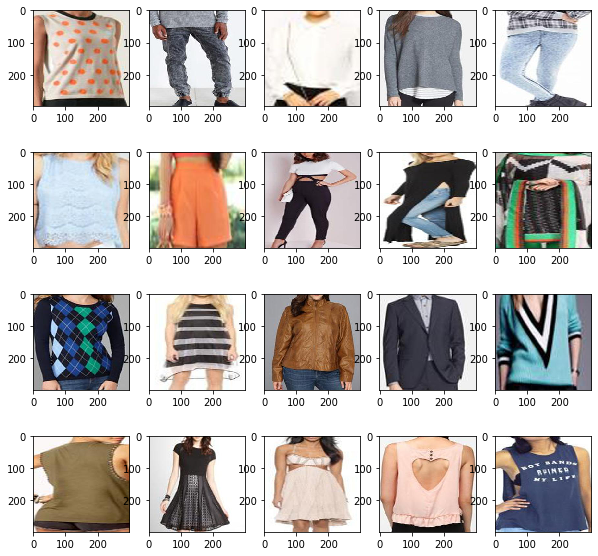

In [5]:
for x_data, t_data in train_generator:
    print('x_data shape : ', x_data.shape) # (20,299,299,3)
    print('t_data shape : ', t_data.shape) # (20,)
    break;

fig = plt.figure(figsize=(10,10))
axs = []

for i in range(20):
    axs.append(fig.add_subplot(4,5,i+1))
    
for x_data, t_data in train_generator:
    for idx, img_data in enumerate(x_data): # idx => 0~19 , img_data =>(150,150,3)
        axs[idx].imshow(img_data)
    print(t_data)
    break;
    
fig.tight_layout()
plt.show()


In [6]:

callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',  # 검증 정확도 모니터링
                                                   patience=5),             # 1 epoch보다 더 길게 정확도 향상되지 않으면 훈련 중지
                  
                  tf.keras.callbacks.ModelCheckpoint(filepath='./classifier_category_model_MobileNetV2_1203.h5',
                                                     monitor='val_loss',    # 검증 loss 모니터링
                                                     save_best_only=True),  # 가장 좋은 모델을 저장
                  
                  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',  # 검증 loss 모니터링
                                                      factor=0.1,           # 콜백 호출시 학습률 10배로 줄임
                                                      patience=5)]          # 검증손실이 해당 epoch만큼 좋아지지 않으면 콜백 호출

In [7]:
    
conv_base = MobileNetV2(weights='imagenet',
              include_top=False,
              input_shape=(299, 299, 3))

print(conv_base.summary())

conv_base.trainable = False  # Convolution Layer 동결


# model.add(conv_base)


9412608/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 301, 301, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 150, 150, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 150, 150, 32) 128         Conv1[0][0]                      
________________

__________________________________________________________________________________________________
None


In [11]:
model = Sequential()

model.add(conv_base)
model.add(GlobalAveragePooling2D())

model.add(Flatten())    
model.add(Dropout(rate=0.5))

model.add(Dense(units=512, activation='relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(units=33, activation='softmax'))

print(model.summary())


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 10, 10, 1280)      2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               655872    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)              

In [12]:
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
history = model.fit(train_generator,
                    steps_per_epoch=1000,
                    epochs=20,
                    callbacks=callbacks_list,
                    validation_data=validation_generator,
                    validation_steps=50)
                    
# (len(train_list)*0.8)/batch_size
# (len(train_list)*0.2)/batch_size

Epoch 1/20
1000/1000 [==============================] - 404s 404ms/step - loss: 1.7788 - accuracy: 0.4787 - val_loss: 1.3874 - val_accuracy: 0.5872 - lr: 0.0010
Epoch 2/20
1000/1000 [==============================] - 404s 404ms/step - loss: 1.5560 - accuracy: 0.5326 - val_loss: 1.3134 - val_accuracy: 0.6092 - lr: 0.0010
Epoch 3/20
1000/1000 [==============================] - 369s 369ms/step - loss: 1.5029 - accuracy: 0.5461 - val_loss: 1.2781 - val_accuracy: 0.6152 - lr: 0.0010
Epoch 4/20
1000/1000 [==============================] - 356s 356ms/step - loss: 1.4764 - accuracy: 0.5528 - val_loss: 1.2364 - val_accuracy: 0.6280 - lr: 0.0010
Epoch 5/20
1000/1000 [==============================] - 355s 355ms/step - loss: 1.4652 - accuracy: 0.5566 - val_loss: 1.2428 - val_accuracy: 0.6286 - lr: 0.0010
Epoch 6/20
1000/1000 [==============================] - 356s 356ms/step - loss: 1.4454 - accuracy: 0.5601 - val_loss: 1.2529 - val_accuracy: 0.6204 - lr: 0.0010
Epoch 7/20
1000/1000 [============

In [ ]:
# 기학습 된 모델 불러오기
model = tf.keras.models.load_model('./classifier_category_model_MobileNetV2_1203.h5')

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


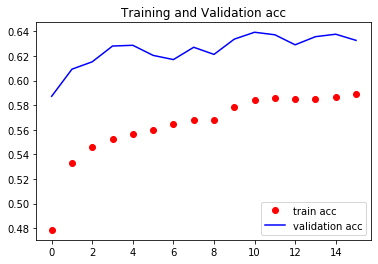

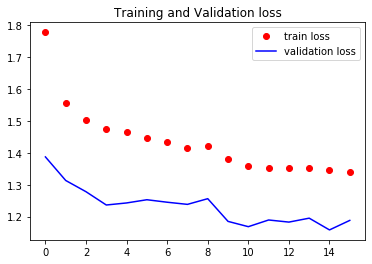

In [14]:
print(history.history.keys())

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_acc, 'bo', color='r', label='train acc')
plt.plot(val_acc, 'b', color='b', label='validation acc')
plt.title('Training and Validation acc')
plt.legend()
plt.show()

plt.plot(train_loss, 'bo', color='r', label='train loss')
plt.plot(val_loss, 'b', color='b', label='validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [19]:
!pip install graphviz

In [17]:
!pip install pydot

In [21]:
from tensorflow.keras.utils import plot_model
import pydot
plot_model(model, to_file='model.png')
plot_model(model, show_shapes=True, to_file='model_shape.png')


Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [22]:

from tensorflow.keras.utils import plot_model

plot_model(conv_base, to_file='model.png')
plot_model(conv_base, show_shapes=True, to_file='model_shape.png')


Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
